# **1. Importing the unimputed dataset**


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [21]:
data = pd.read_csv("../UnImputedDataWithIDs.csv").drop(columns = ["Unnamed: 0", "ID"], axis=1)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27544 entries, 0 to 27543
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Quarter              27544 non-null  int64  
 1   Year                 27544 non-null  int64  
 2   District             27544 non-null  object 
 3   Price (billion VND)  27544 non-null  float64
 4   Area (m2)            26903 non-null  float64
 5   Property Type        27544 non-null  object 
 6   Floors               14938 non-null  float64
 7   Bathrooms            14166 non-null  float64
 8   Entrance (m2)        12213 non-null  float64
 9   Bedrooms             15710 non-null  float64
 10  Living Rooms         13192 non-null  float64
 11  Law Document         27544 non-null  object 
dtypes: float64(7), int64(2), object(3)
memory usage: 2.5+ MB


# **2. Defining methods to detect multicollinearity**


In [4]:
def numerical_convert(data: pd.DataFrame, categorical_encoder) -> any:
    """ Return the converted DataFrame and the transformation dictionary """
    transform_dict = dict()
    converted_data = data.copy()
    object_cols = data.select_dtypes(include=["object"]).columns
    for col in object_cols:
        converted_data[col] = categorical_encoder.fit_transform(data[[col]])
        transform_dict[col] = list(zip(converted_data[col].unique(), data[col].unique()))
    return converted_data, transform_dict
    
def correlation_map(converted_data: pd.DataFrame) -> None:
    """ Showing the correlation between any 2 variables """
    corr_matrix = converted_data.corr()
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5, linecolor="black")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.title("Correlations between every 2 fields", fontweight="bold")
    return

def VIF_values(converted_data: pd.DataFrame):
    """ Showing the Variance Inflation Factor (VIF) for each field """
    X = add_constant(converted_data)
    vif_df = pd.DataFrame()
    vif_df["Fields"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_df

In [23]:
converted_data, transformation = numerical_convert(data=data, categorical_encoder= OrdinalEncoder())
# A complete-case dataset
converted_completed_data = converted_data.dropna(ignore_index=True)

## **2.1. Correlation matrix visualized for unimputed dataset**


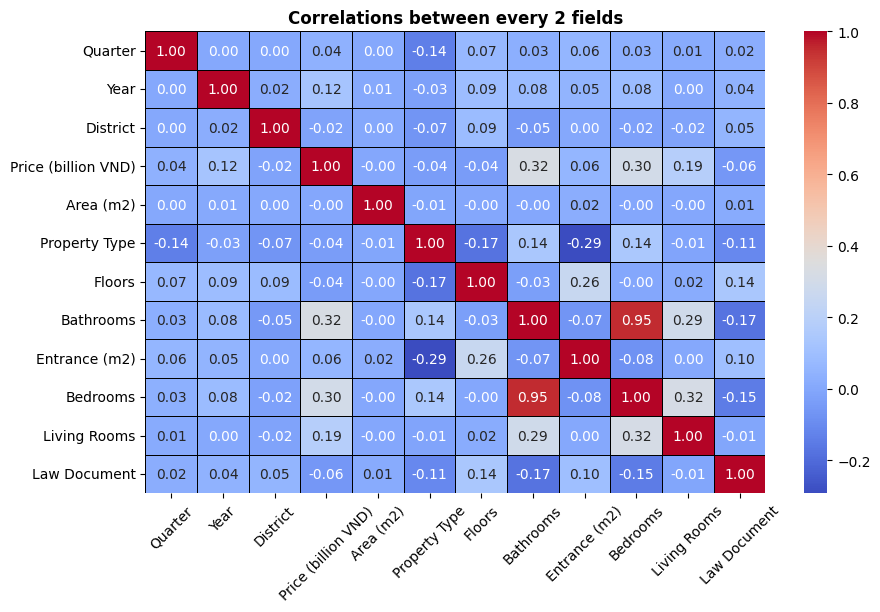

In [24]:
# Correlation between any 2 fields
correlation_map(converted_data)

## **2.2. Correlation matrix visualized for the Complete Case Dataset**


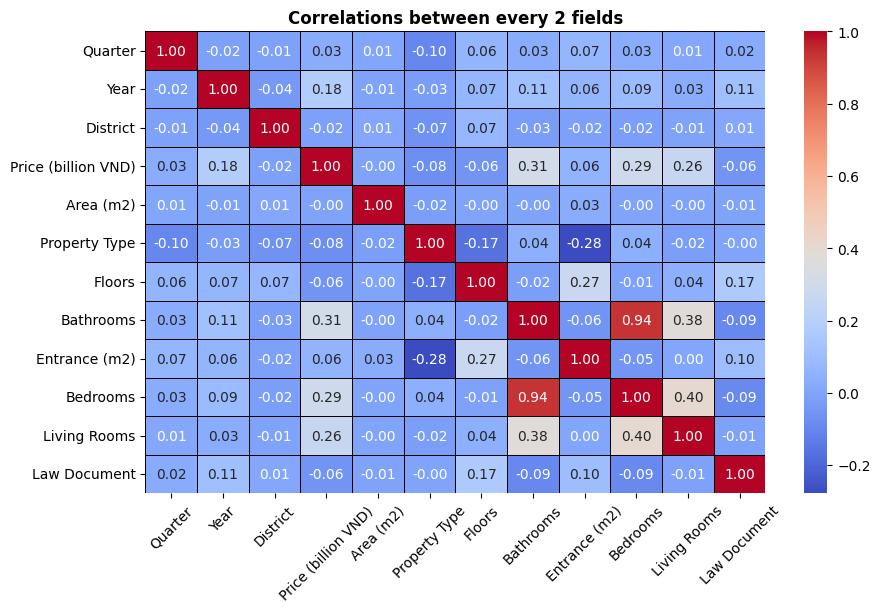

In [25]:
correlation_map(converted_completed_data)

## **2.3. The Variance Inflation Factor (VIF) for each field in the Complete Case Dataset**


In [26]:
print(VIF_values(converted_completed_data))

                 Fields           VIF
0                 const  2.161997e+06
1               Quarter  1.016824e+00
2                  Year  1.066320e+00
3              District  1.014248e+00
4   Price (billion VND)  1.187947e+00
5             Area (m2)  1.001378e+00
6         Property Type  1.118034e+00
7                Floors  1.134460e+00
8             Bathrooms  8.546614e+00
9         Entrance (m2)  1.166049e+00
10             Bedrooms  8.612539e+00
11         Living Rooms  1.236094e+00
12         Law Document  1.057819e+00


# **3. Checking for multicollinearity among the predictors**

_These predictors are specified in the **preds_dict** of the <code>main.py</code> file._


In [9]:
predictors_data = converted_data[["Quarter", "Year", "District", "Price (billion VND)", "Property Type", "Law Document"]]
predictors_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27544 entries, 0 to 27543
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Quarter              27544 non-null  int64  
 1   Year                 27544 non-null  int64  
 2   District             27544 non-null  float64
 3   Price (billion VND)  27544 non-null  float64
 4   Property Type        27544 non-null  float64
 5   Law Document         27544 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 1.3 MB


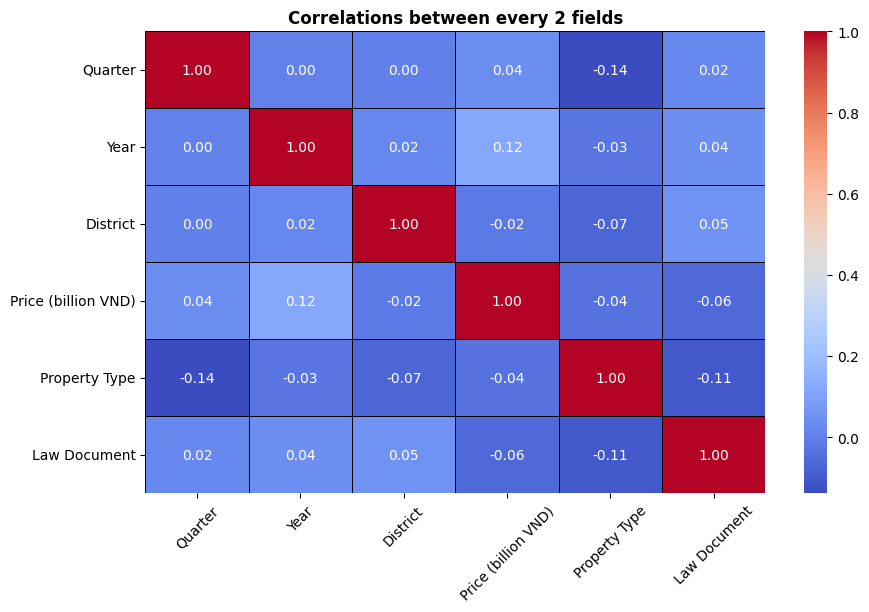

In [10]:
correlation_map(predictors_data)

In [11]:
VIF_values(predictors_data)

,Fields,VIF
0,const,1.692342e+06
1,Quarter,1.021007e+00
2,Year,1.018140e+00
3,District,1.007802e+00
4,Price (billion VND),1.022742e+00
5,Property Type,1.037476e+00
6,Law Document,1.020019e+00


# **4. Scaling the data**

_Might be necessary for different imputation strategies, the current strategy used here is "mode"._


In [12]:
converted_data.head()

,ID,Quarter,Year,District,Price (billion VND),Area (m2),Property Type,Floors,Bathrooms,Entrance (m2),Bedrooms,Living Rooms,Law Document
0,0,4,2024,13.0,6.200,133.1,1.0,18.0,3.0,2.0,4.0,1.0,6.0
1,1,3,2024,19.0,16.450,200.0,1.0,NaN,NaN,NaN,NaN,NaN,7.0
2,2,3,2024,32.0,13.793,144.0,1.0,NaN,3.0,NaN,3.0,1.0,4.0
3,4,3,2024,26.0,5.277,80.0,1.0,NaN,NaN,NaN,NaN,NaN,7.0
4,5,3,2024,26.0,4.300,80.0,1.0,NaN,NaN,NaN,NaN,NaN,7.0


In [13]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaled_data = scaler.fit_transform(converted_data)
scaled_df = pd.DataFrame(scaled_data, columns = converted_data.columns)

In [14]:
scaled_df.head()

,ID,Quarter,Year,District,Price (billion VND),Area (m2),Property Type,Floors,Bathrooms,Entrance (m2),Bedrooms,Living Rooms,Law Document
0,-1.083575,2.0,1.0,0.166667,0.130435,1.168519,-0.5,6.5,0.0,-0.518519,0.5,0.0,0.00
1,-1.083516,1.0,1.0,0.500000,1.244565,2.407407,-0.5,NaN,NaN,NaN,NaN,NaN,0.25
2,-1.083458,1.0,1.0,1.222222,0.955761,1.370370,-0.5,NaN,0.0,NaN,0.0,0.0,-0.50
3,-1.083341,1.0,1.0,0.888889,0.030109,0.185185,-0.5,NaN,NaN,NaN,NaN,NaN,0.25
4,-1.083282,1.0,1.0,0.888889,-0.076087,0.185185,-0.5,NaN,NaN,NaN,NaN,NaN,0.25


In [15]:
unscaled_data = scaler.inverse_transform(scaled_df)
unscaled_df = pd.DataFrame(unscaled_data, columns = scaled_df.columns)

In [16]:
unscaled_df.head()

,ID,Quarter,Year,District,Price (billion VND),Area (m2),Property Type,Floors,Bathrooms,Entrance (m2),Bedrooms,Living Rooms,Law Document
0,3.637979e-12,4.0,2024.0,13.0,6.200,133.1,1.0,18.0,3.0,2.0,4.0,1.0,6.0
1,1.000000e+00,3.0,2024.0,19.0,16.450,200.0,1.0,NaN,NaN,NaN,NaN,NaN,7.0
2,2.000000e+00,3.0,2024.0,32.0,13.793,144.0,1.0,NaN,3.0,NaN,3.0,1.0,4.0
3,4.000000e+00,3.0,2024.0,26.0,5.277,80.0,1.0,NaN,NaN,NaN,NaN,NaN,7.0
4,5.000000e+00,3.0,2024.0,26.0,4.300,80.0,1.0,NaN,NaN,NaN,NaN,NaN,7.0


# **5. Checking the ModeImputedData for correlation**


In [18]:
mode_imputed = pd.read_csv("../ModeImputedDatawithIDs.csv").drop(columns = ["Unnamed: 0", "ID"], axis=1)

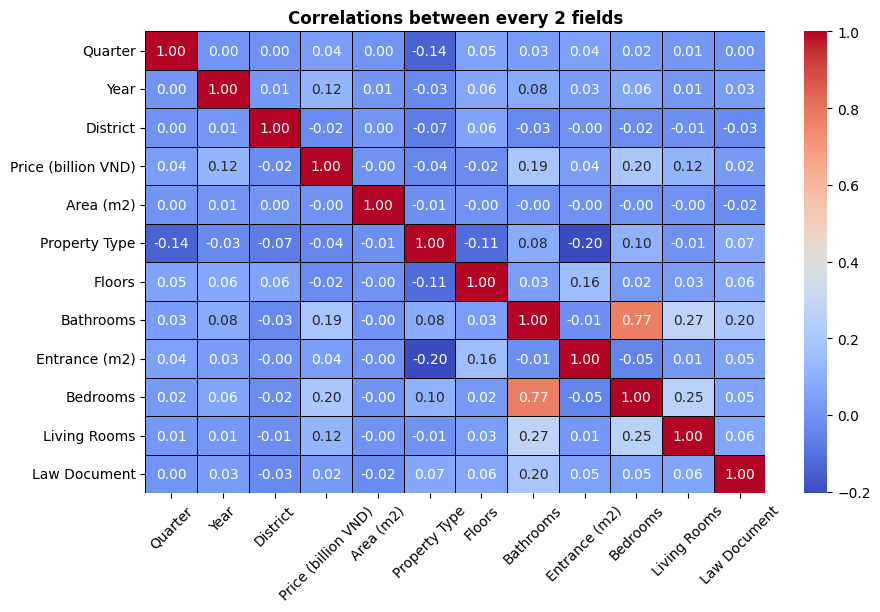

In [19]:
numerical_mode = numerical_convert(mode_imputed, categorical_encoder= OrdinalEncoder())[0]
correlation_map(numerical_mode)

In [20]:
print(VIF_values(numerical_mode))

                 Fields           VIF
0                 const  1.702123e+06
1               Quarter  1.023836e+00
2                  Year  1.024074e+00
3              District  1.009487e+00
4   Price (billion VND)  1.071573e+00
5             Area (m2)  1.000656e+00
6         Property Type  1.097924e+00
7                Floors  1.047990e+00
8             Bathrooms  2.672218e+00
9         Entrance (m2)  1.070177e+00
10             Bedrooms  2.581978e+00
11         Living Rooms  1.091971e+00
12         Law Document  1.083438e+00


## The heatmap and VIF values have shown that:

- There is **no severe multicollinearity** in our dataset after imputations.
- However, there is **collinearity** between the <code>Bathrooms</code> and <code>Bedrooms</code>.
